In [1]:
using ITensors, Plots, LaTeXStrings
using ProgressMeter, Graphs, LinearAlgebra
using Combinatorics
using Statistics
push!(LOAD_PATH, "functions/")
using BP, Ising2D

include("dependencies.jl")
include("functions/ClusterEnumeration.jl")
include("randompeps.jl")
using Test
using Serialization

In [2]:
N = 2
T = N

noise = 0
ti = true   
orthog = false   
normalise = false 
η = 10.
annealing = 0.9
tensors, peps = peps_controllable(N, T; η=η, ti=ti, orthog=orthog, noise=noise, biasing=true)
exact_result = contract_peps_no_phys(peps; cutoff=1E-12, maxdim=64)
println("exact ", exact_result)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors, edges, links) 
messages , arr  = BP.message_passing(tensors, messages, edges, adj_mat; 
                                α=annealing, max_iters=500, diagnose=true, normalise=true)
Z_list = BP.get_fixed_point_list(tensors,messages,adj_mat)    
tensors = BP.normalize_tensors(tensors,Z_list)                      
Z = prod(Z_list)
println("BP vacuum ", Z)

for (i, edge) in enumerate(edges)
    contribution = scalar(BP.loop_contribution([edge], messages, tensors, edges, links, adj_mat))
    println("  Edge $i $edge: $contribution")
end

Zloop = scalar(BP.loop_contribution(edges, messages, tensors, edges, links, adj_mat))  
println("BP loop ", Z * (1 + Zloop))



exact 456.9420236406034
BP vacuum 456.725400867456 + 0.0im
  Edge 1 (1, 2): 0.0 + 4.4942565968015e-19im
  Edge 2 (1, 3): 0.0 + 2.6964714358817877e-17im
  Edge 3 (2, 4): 0.0 - 1.4942065488014942e-16im
  Edge 4 (3, 4): 0.0 + 7.775853973965168e-17im
BP loop 456.94202364060334 + 0.0im


In [13]:
include("tc.jl")

# Parameters
Ls = 4 
p = 0.05
L = 4
numsamples = 100
max_loop_order = 8
pcmat = toric_code_X_parity_matrix(L)
μ_logical_loops, σ_logical_loops, μ_failure_loops, σ_failure_loops,
        μ_logical_no_loops, σ_logical_no_loops, μ_failure_no_loops, σ_failure_no_loops = decode(pcmat, p, numsamples, L; pbias=p, max_loop_order=max_loop_order)

Samples: 100%|████████████████████████████| Time: 0:00:09 (99.39 ms/it)


(0.07, 0.2564323999762428, 0.07, 0.2564323999762428, 0.13, 0.33799766898963113, 0.13, 0.33799766898963113)

In [5]:
# Generate all combinations of length k for k = 0 to length(list)
contri = 1
for k in 1:length(edges)
    for combo in combinations(edges, k)
        loopcont = scalar(BP.loop_contribution(combo, messages, tensors, edges, links, adj_mat))
        contri += loopcont
        println("Subset ", combo, ", contri ",loopcont)
    end
end
contri * Z

Subset [(1, 2)], contri 0.0 + 4.4942565968015e-19im
Subset [(1, 3)], contri 0.0 + 2.6964714358817877e-17im
Subset [(2, 4)], contri 0.0 - 1.4942065488014942e-16im
Subset [(3, 4)], contri 0.0 + 7.775853973965168e-17im
Subset [(1, 2), (1, 3)], contri -1.1704132975331401e-33 + 0.0im
Subset [(1, 2), (2, 4)], contri 0.0 - 9.315213986374353e-36im
Subset [(1, 2), (3, 4)], contri -3.3604826546350705e-35 + 0.0im
Subset [(1, 3), (2, 4)], contri 5.191312783478821e-33 + 0.0im
Subset [(1, 3), (3, 4)], contri 0.0 + 2.3538055152835842e-33im
Subset [(2, 4), (3, 4)], contri -1.0839912286385852e-32 + 0.0im
Subset [(1, 2), (1, 3), (2, 4)], contri -1.4555881847297856e-35 + 0.0im
Subset [(1, 2), (1, 3), (3, 4)], contri -1.4899004105694042e-35 + 0.0im
Subset [(1, 2), (2, 4), (3, 4)], contri 8.950874384835479e-35 + 0.0im
Subset [(1, 3), (2, 4), (3, 4)], contri -5.95243248219059e-36 + 0.0im
Subset [(1, 2), (1, 3), (2, 4), (3, 4)], contri 0.0004742954360232542 + 0.0im


456.94202364060334 - 2.0209174175168543e-14im

In [ ]:

L = 3 
β = 0.2
tensors = Ising2D.get_ising_tn(L,β)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=1.0,max_iters=500,diagnose=false,normalise=true)


In [3]:
function symmetrize_itensor(T::ITensor)
    indx = inds(T)
    n = length(indx)
    perms = collect(permutations(1:n))
    S = zero(T)
    for perm in perms
        S += permute(T, indx[perm])
    end
    S /= length(perms)
    return S
end 

function pad_with_zeros(arr::Vector{Float64}, x::Int)
    n = length(arr)
    if n >= x
        return arr
    else
        return vcat(arr, zeros(x - n))
    end
end

function ortho(T::ITensor, v::Vector{Float64})
    indx = inds(T)
    n = length(indx)
    for idx in indx 
        vec = ITensor(v,idx)
        vec = vec / norm(vec)
        T = T - (T * vec) * vec 
        T = T / norm(T)
    end 
    return T 
end 

function controllable_tensor(i1_in,i2_in,i1_out,i2_out;η=0,orthog=true,noise=0,biasing=false)
    ## all vectors same for now in a tensor 
    ## η = mixing factor of non-rank-1 garbage
    ## ortho = true orthogonalizes the garbage tensor w.r.t. the rank-1 part
    ## assumed all i1_in,i2_in,i1_out,i2_out are of the same dimension
    vec = biasing ? (ones(dim(i1_in)) + noise * rand(dim(i1_in)))  :  rand(dim(i1_in))
    vec = vec / norm(vec)
    fp = ITensor(vec,i1_in) * ITensor(vec,i2_in) * ITensor(vec,i1_out) * ITensor(vec,i2_out)
    fp = fp / norm(fp)
    fm = orthog ? ortho(randomITensor(i1_in,i2_in,i1_out,i2_out),vec) : randomITensor(i1_in,i2_in,i1_out,i2_out)
    fm = fm / norm(fm)
    f = fp + η * fm 
    # f = f / norm(f)
    return f
end 

controllable_tensor (generic function with 1 method)

In [5]:
function peps_controllable(N, T; η=0, ti=true, orthog=true, noise = 0, biasing = false)
    ## if ti = true all tensors are identical, else all random, different
    χ = 2
    vinds = [Index(χ, "v$(n)t$(t)") for n in 1:N, t in 1:T-1]
    hinds = [Index(χ, "n$(n)h$(t)") for n in 1:N-1, t in 1:T]

    down, up, left, right = Index(2,"down"), Index(2,"up"), Index(2,"left"), Index(2,"right")
    tens_main = controllable_tensor(down, up, left, right; η=η, orthog=orthog,noise=noise,biasing=biasing)

    tensors = []

    for n = 1:N
        for t = 1:T
            if ti 
                tens = copy(tens_main)
            else 
                down, up, left, right = Index(2,"down"), Index(2,"up"), Index(2,"left"), Index(2,"right")
                tens = controllable_tensor(down, up, left, right; η=η, orthog=orthog,noise=noise,biasing=biasing)
            end 
            # Vertical connections (up/down)
            if t == 1
                tens *= ITensor([1.,1.] ./ sqrt(2), down)
                tens *= delta(up, vinds[n, t])
            elseif t == T
                tens *= ITensor([1.,1.] ./ sqrt(2), up)
                tens *= delta(down, vinds[n, t - 1])
            else
                tens *= delta(down, vinds[n, t - 1])
                tens *= delta(up, vinds[n, t])
            end

            # Horizontal connections (left/right)
            if n == 1
                tens *= ITensor([1.,1.] ./ sqrt(2), left)
                tens *= delta(right, hinds[n, t])
            elseif n == N
                tens *= ITensor([1.,1.] ./ sqrt(2), right)
                tens *= delta(left, hinds[n - 1, t])
            else
                tens *= delta(left, hinds[n - 1, t])
                tens *= delta(right, hinds[n, t])
            end

            push!(tensors, tens)
        end
    end

    return tensors
end



function peps_controllable_ti(N, T, tens_main)
    ## if ti = true all tensors are identical, else all random, different
    χ = 2
    vinds = [Index(χ, "v$(n)t$(t)") for n in 1:N, t in 1:T-1]
    hinds = [Index(χ, "n$(n)h$(t)") for n in 1:N-1, t in 1:T]

    down, up, left, right = inds(tens_main)

    tensors = []

    for n = 1:N
        for t = 1:T
            tens = copy(tens_main)
            # Vertical connections (up/down)
            if t == 1
                tens *= ITensor([1.,1.] ./ sqrt(2), down)
                tens *= delta(up, vinds[n, t])
            elseif t == T
                tens *= ITensor([1.,1.] ./ sqrt(2), up)
                tens *= delta(down, vinds[n, t - 1])
            else
                tens *= delta(down, vinds[n, t - 1])
                tens *= delta(up, vinds[n, t])
            end

            # Horizontal connections (left/right)
            if n == 1
                tens *= ITensor([1.,1.] ./ sqrt(2), left)
                tens *= delta(right, hinds[n, t])
            elseif n == N
                tens *= ITensor([1.,1.] ./ sqrt(2), right)
                tens *= delta(left, hinds[n - 1, t])
            else
                tens *= delta(left, hinds[n - 1, t])
                tens *= delta(right, hinds[n, t])
            end

            push!(tensors, tens)
        end
    end
    return tensors
end


function peps_controllable_ti_periodic(N, T, tens_main)
    # N: number of spatial sites (columns)
    # T: number of time steps (rows)
    # tens_main: base tensor with indices (up, down, left, right)

    χ = 2  # bond dimension

    # Internal vertical bonds (between time steps)
    vinds = [Index(χ, "v$(n)t$(t)") for n in 1:N, t in 1:T-1]

    # Internal horizontal bonds (between spatial sites)
    hinds = [Index(χ, "n$(n)h$(t)") for n in 1:N-1, t in 1:T]

    # Wraparound vertical bonds (connect t = T to t = 1)
    vwrap = [Index(χ, "v$(n)t$(T)_wrap") for n in 1:N]

    # Wraparound horizontal bonds (connect n = N to n = 1)
    hwrap = [Index(χ, "n$(N)h$(t)_wrap") for t in 1:T]

    # Extract index directions from base tensor
    

    tensors = []

    for n = 1:N
        for t = 1:T
            tens = deepcopy(tens_main)
            down, up, left, right = inds(tens)

            # Vertical connections (up/down)
            if t == 1
                # Connect up to bottom of previous (wraparound)
                tens *= delta(up, vwrap[n])
                # Connect down to next layer
                tens *= delta(down, vinds[n, t])
            elseif t == T
                # Connect up to previous layer
                tens *= delta(up, vinds[n, t - 1])
                # Connect down to top (wraparound)
                tens *= delta(down, vwrap[n])
            else
                # Connect to layers above and below
                tens *= delta(up, vinds[n, t - 1])
                tens *= delta(down, vinds[n, t])
            end

            # Horizontal connections (left/right)
            if n == 1
                # Connect left to rightmost site (wraparound)
                tens *= delta(left, hwrap[t])
                # Connect right to next site
                tens *= delta(right, hinds[n, t])
            elseif n == N
                # Connect left to previous site
                tens *= delta(left, hinds[n - 1, t])
                # Connect right to leftmost site (wraparound)
                tens *= delta(right, hwrap[t])
            else
                # Connect to neighbors on left and right
                tens *= delta(left, hinds[n - 1, t])
                tens *= delta(right, hinds[n, t])
            end

            push!(tensors, tens)
        end
    end

    return tensors
end


peps_controllable_ti_periodic (generic function with 1 method)

Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:11Excessive output truncated after 524411 bytes.

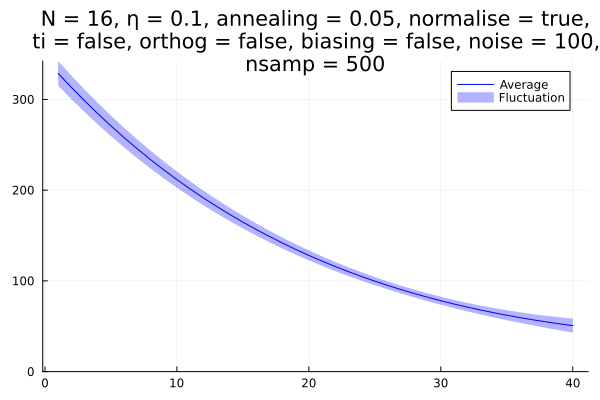

In [ ]:
nsamp = 500 
N = 16
T = N 
maxiter = 40 
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)

η = .1
annealing = .05
noise = 100
ti = false   
orthog = false   
biasing = false  
normalise = true 
@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog,noise=noise,biasing=biasing)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)

x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
# title!(L"N= %$N, \eta = %$η, \alpha = %$annealing, nsamp = %$nsamp")
title!("N = $(N), η = $(η), annealing = $(annealing), normalise = $(normalise),\n" *
       "ti = $(ti), orthog = $(orthog), biasing = $(biasing), noise = $(noise),\n" *
       "nsamp = $(nsamp)")


In [85]:
nsamp = 10  # Set your desired number of samples
annealing = 1.0
maxiter = 40
η = 0.0 
noise = 0.0
normalise = false  # Set as needed
orthog = true     # Set as needed
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
N = 10 
T = N
@showprogress for samp = 1:nsamp
    i1_in, i2_in, i1_out, i2_out = Index(2, "down"), Index(2, "up"), Index(2, "left"), Index(2, "right")
    vec = [1, 1] + noise * rand(dim(i1_in))
    vec = vec / norm(vec)
    fp = ITensor(vec,i1_in) * ITensor(vec,i2_in) * ITensor(vec,i1_out) * ITensor(vec,i2_out)
    fp = fp / norm(fp)
    fm = orthog ? ortho(randomITensor(i1_in,i2_in,i1_out,i2_out),vec) : randomITensor(i1_in,i2_in,i1_out,i2_out)
    fm = fm / norm(fm)
    f = fp + η * fm 
    tens_main = f
    tensors = peps_controllable_ti(N, T, tens_main)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors, edges, links)
    messages, arr = BP.message_passing(
        tensors, messages, edges, links, adj_mat;
        α=annealing, max_iters=maxiter, diagnose=true, normalise=normalise
    )
    inner_pdtmessage_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end


mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)

x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing")

AssertionError: AssertionError: messages decaying to zero!

In [4]:
function pass_messages(tensors,messages,edges,links,adj_mat;α=1,noise=0,normalise=true)
    for e in edges 
        ## want to update the message from v1 → v2 
        v1, v2 = e 
        @assert norm(messages[v1,v2]) > 1e-12 "messages decaying to zero!"
        update = tensors[v1]
        for nbr in BP.get_nbrs(adj_mat, v1)
            if nbr != v2 
                update = update * messages[nbr,v1]
            end
        end 
        # println(check_permutation_indices(messages[v1,v2],update))
        new_message = normalise ? update/norm(update) : update 
        inde = inds(messages[v1,v2])[1]
        messages[v1,v2] = (1-α) * messages[v1,v2] + α * new_message 
                                + noise * ITensor(randn(dim(inde)),inde)
        messages[v1,v2] = normalise ? messages[v1,v2] / norm(messages[v1,v2]) : messages[v1,v2]

    end 
    
    # backward
    
    for e in edges
        
        ## want to update the message from v1 → v2 
        v2, v1 = e 
        @assert norm(messages[v1,v2]) > 1e-12 "messages decaying to zero!"
        update = tensors[v1]
        for nbr in BP.get_nbrs(adj_mat, v1)
            if nbr != v2 
                update = update * messages[nbr,v1] 
            end
        end 
        # println(check_permutation_indices(messages[v1,v2],update))
        new_message = normalise ? update/norm(update) : update 
        inde = inds(messages[v1,v2])[1]
        messages[v1,v2] = (1-α) * messages[v1,v2] + α * new_message 
                                + noise * ITensor(randn(dim(inde)),inde)
        messages[v1,v2] = normalise ? messages[v1,v2] / norm(messages[v1,v2]) : messages[v1,v2]
    end   
    return messages 
end

function distance_from_fixed_point(tensors,messages,edges,links,adj_mat,fp)
    dist = zeros(length(edges))
    for (i,e) in enumerate(edges) 
        v,w = e 
        m = messages[v,w]
        dist[i] = norm(m - ITensor(fp,inds(m)[1]))
    end 
    return dist
end 

distance_from_fixed_point (generic function with 1 method)

In [52]:
annealing = 1.0
maxiter = 40
η = 0.0 
noise = .1
normalise = true  # Set as needed
orthog = true     # Set as needed
N = 10 
T = N
i1_in, i2_in, i1_out, i2_out = Index(2, "down"), Index(2, "up"), Index(2, "left"), Index(2, "right")
vec = [1, 1] + noise * rand(dim(i1_in))
vec = vec / norm(vec)
fp = ITensor(vec,i1_in) * ITensor(vec,i2_in) * ITensor(vec,i1_out) * ITensor(vec,i2_out)
fp = fp / norm(fp)
fm = orthog ? ortho(randomITensor(i1_in,i2_in,i1_out,i2_out),vec) : randomITensor(i1_in,i2_in,i1_out,i2_out)
fm = fm / norm(fm)
f = fp + η * fm 
tens_main = f
tensors = peps_controllable_ti(N, T, tens_main)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors, edges, links)

time_steps = 10
distances = zeros(Float64,time_steps,length(edges))

for t = 1:time_steps 
    messages = pass_messages(tensors,messages,edges,links,adj_mat;α=annealing,normalise=normalise)
    println(norm(messages[1,2] - ITensor(vec,inds(messages[1,2])[1])))
    distances[t,:] = distance_from_fixed_point(tensors,messages,edges,links,adj_mat,vec)
end 


1.1102230246251565e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16
1.5700924586837752e-16


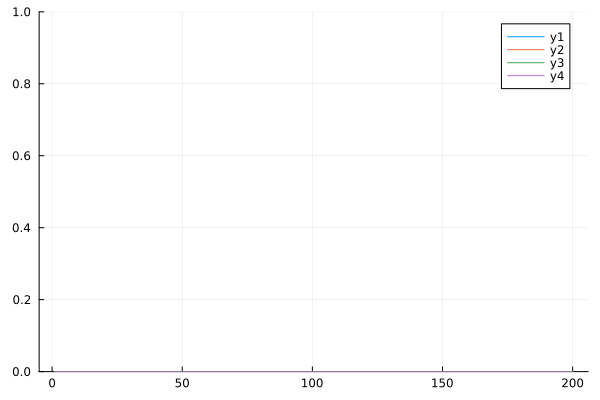

In [51]:
plot(distances[1,:],ylims=(0,1))
plot!(distances[2,:])
plot!(distances[3,:])
plot!(distances[4,:])
# plot!(distances[5,:])

In [ ]:
noise = .0001
tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog,noise=noise)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
# messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=false)
# print(messages[1,2])
e = rand(edges)
v1, v2 = e 
# @assert norm(messages[v1,v2]) > 1e-12 "messages decaying to zero!"
update = tensors[v1]
for nbr in BP.get_nbrs(adj_mat, v1)
    if nbr != v2 
        update = update * messages[nbr,v1]
    end
end 
println(norm(update - ITensor([1,1]./sqrt(2),inds(update)[1])))

In [62]:
noise = 1e-5
vec = [1, 1] + noise * rand(2)
vec = vec / norm(vec)
r = norm(vec - [1., 1.]./sqrt(2))
D = 2 
ϵ = η
Δ = 4 

# r_ar = LinRange(1e-3,1,100)
# plot(r_ar,r_ar .- [(ϵ * D^Δ) / ((ϵ * D^Δ) + (1-r^2)^((Δ-1)/2)) for r in r_ar])
# κs = [((1-r^2)^((Δ-1)/2) + (ϵ * D^Δ) * r * (Δ-2)) for r in r_ar]

r, (ϵ * D^Δ) / ((ϵ * D^Δ) + (1-r^2)^((Δ-1)/2)), ((1-r^2)^((Δ-1)/2) + (ϵ * D^Δ) * r * (Δ-2))

(1.975289513708248e-6, 0.6153846153860006, 1.0000063209205912)

1.7722824106111478e-5


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


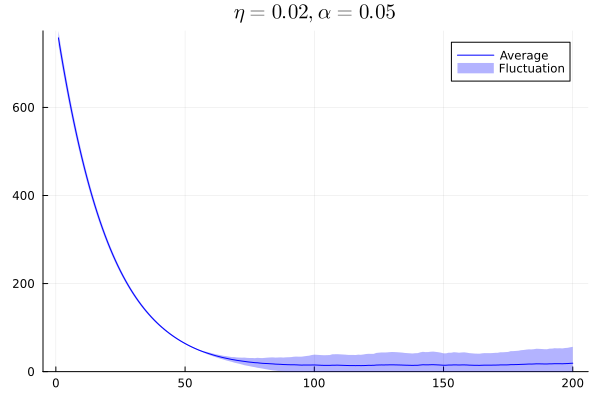

In [15]:
nsamp = 25 
N = 24 
T = 24 
maxiter = 200 
# message_diagnosis = zeros(Float64,maxiter)
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
η = 0.02
annealing = .05 
ti = false 
orthog = false 

@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=true)
    # message_diagnosis = message_diagnosis .+ pad_with_zeros(Float64.(arr),maxiter) 
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)


# plot(
#     collect(1:maxiter),
#     (mean_diagnosis)[1,:],
#     ribbon=max.((fluctuations)[1,:],0.0),
#     title=L"\eta = %$η, \alpha = %$annealing",
#     label="Average ± Fluctuation"
# )


x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


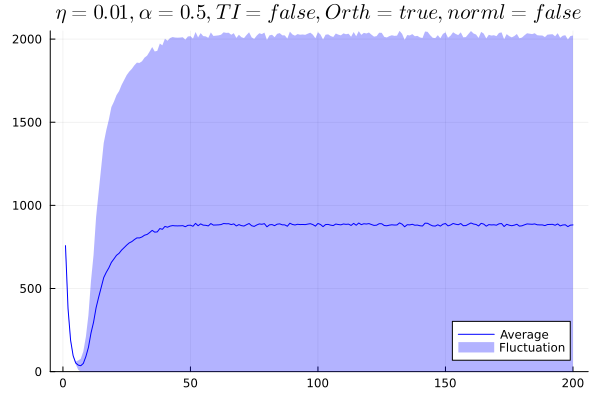

In [31]:
nsamp = 10 
N = 24 
T = 24 
maxiter = 200 
# message_diagnosis = zeros(Float64,maxiter)
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
η = 0.01
annealing = .5
ti = false 
orthog = true 
normalise = false 

@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
    # message_diagnosis = message_diagnosis .+ pad_with_zeros(Float64.(arr),maxiter) 
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)


# plot(
#     collect(1:maxiter),
#     (mean_diagnosis)[1,:],
#     ribbon=max.((fluctuations)[1,:],0.0),
#     title=L"\eta = %$η, \alpha = %$annealing",
#     label="Average ± Fluctuation"
# )


x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing, {TI}=%$(ti), {Orth}=%$(orthog), {norml}=%$(normalise)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


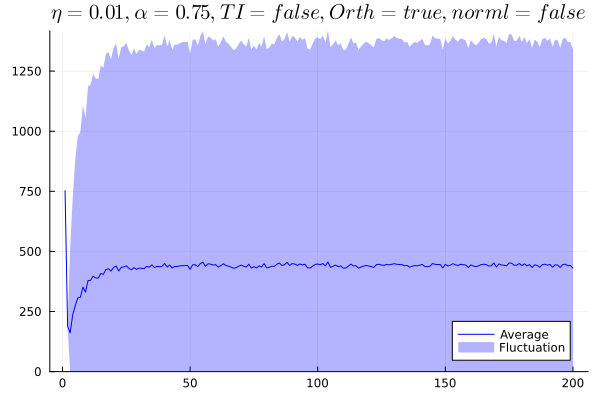

In [32]:
nsamp = 10 
N = 24 
T = 24 
maxiter = 200 
# message_diagnosis = zeros(Float64,maxiter)
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
η = 0.01
annealing = .75
ti = false 
orthog = true 
normalise = false 

@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
    # message_diagnosis = message_diagnosis .+ pad_with_zeros(Float64.(arr),maxiter) 
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)


# plot(
#     collect(1:maxiter),
#     (mean_diagnosis)[1,:],
#     ribbon=max.((fluctuations)[1,:],0.0),
#     title=L"\eta = %$η, \alpha = %$annealing",
#     label="Average ± Fluctuation"
# )


x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing, {TI}=%$(ti), {Orth}=%$(orthog), {norml}=%$(normalise)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


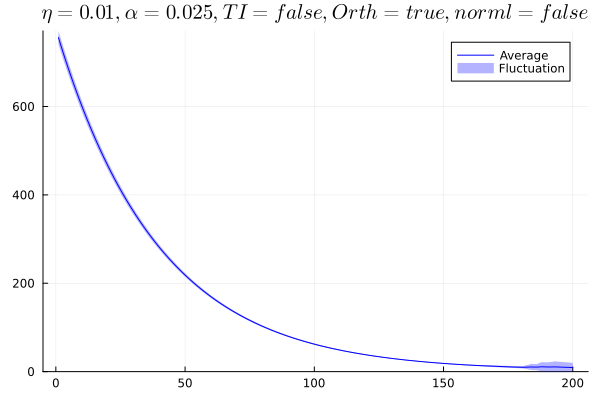

In [35]:
nsamp = 10 
N = 24 
T = 24 
maxiter = 200 
# message_diagnosis = zeros(Float64,maxiter)
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
η = 0.01
annealing = .025
ti = false 
orthog = true 
normalise = false 

@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
    # message_diagnosis = message_diagnosis .+ pad_with_zeros(Float64.(arr),maxiter) 
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)


# plot(
#     collect(1:maxiter),
#     (mean_diagnosis)[1,:],
#     ribbon=max.((fluctuations)[1,:],0.0),
#     title=L"\eta = %$η, \alpha = %$annealing",
#     label="Average ± Fluctuation"
# )


x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing, {TI}=%$(ti), {Orth}=%$(orthog), {norml}=%$(normalise)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


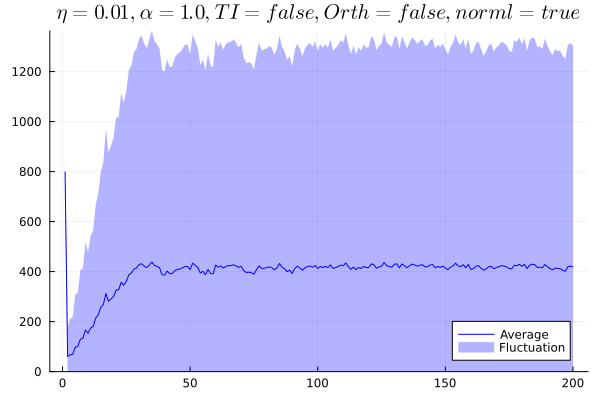

In [ ]:
nsamp = 10 
N = 24 
T = 24 
maxiter = 200 
# message_diagnosis = zeros(Float64,maxiter)
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
η = 0.01
annealing = 1.
ti = false  
orthog = false 
normalise = true 

@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
    # message_diagnosis = message_diagnosis .+ pad_with_zeros(Float64.(arr),maxiter) 
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)


# plot(
#     collect(1:maxiter),
#     (mean_diagnosis)[1,:],
#     ribbon=max.((fluctuations)[1,:],0.0),
#     title=L"\eta = %$η, \alpha = %$annealing",
#     label="Average ± Fluctuation"
# )


x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing, {TI}=%$(ti), {Orth}=%$(orthog), {norml}=%$(normalise)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


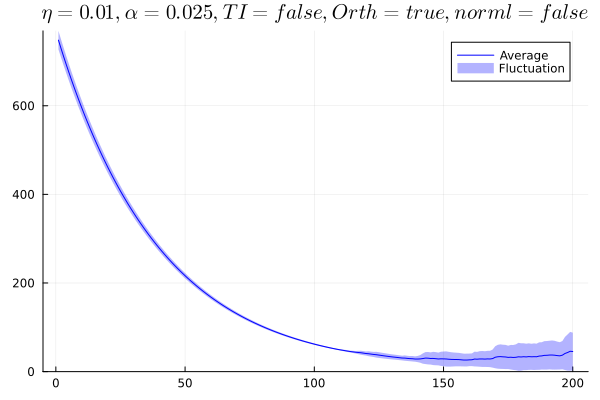

In [30]:
nsamp = 10 
N = 24 
T = 24 
maxiter = 200 
# message_diagnosis = zeros(Float64,maxiter)
message_diagnosis_samples = zeros(Float64, nsamp, maxiter)
η = 0.01
annealing = .025
ti = false 
orthog = true 
normalise = false 

@showprogress for samp = 1:nsamp 
    tensors = peps_controllable(N,T;η=η,ti=ti,orthog=orthog)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links) 
    messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
    # message_diagnosis = message_diagnosis .+ pad_with_zeros(Float64.(arr),maxiter) 
    message_diagnosis_samples[samp, :] = pad_with_zeros(Float64.(arr), maxiter)
end 

mean_diagnosis = mean(message_diagnosis_samples, dims=1)
fluctuations = std(message_diagnosis_samples, dims=1)


# plot(
#     collect(1:maxiter),
#     (mean_diagnosis)[1,:],
#     ribbon=max.((fluctuations)[1,:],0.0),
#     title=L"\eta = %$η, \alpha = %$annealing",
#     label="Average ± Fluctuation"
# )


x = collect(1:maxiter)
y = (mean_diagnosis)[1, :]
fluct = (fluctuations)[1, :]

upper = y .+ fluct
lower = max.(y .- fluct, 0.0)  # Cap at zero

# Plot the mean line
plot(x, y, label="Average", color=:blue)

# Fill the area between upper and lower
plot!(x, upper, fillrange=lower, fillalpha=0.3, label="Fluctuation", color=:blue,linecolor=:transparent)

# Optional: Set y-axis lower limit to zero for extra safety
ylims!((0, :auto))
title!(L"\eta = %$η, \alpha = %$annealing, {TI}=%$(ti), {Orth}=%$(orthog), {norml}=%$(normalise)")

In [ ]:
nsamp = 50 
orthog = true  
normalise = false 


N = 10 
T = N 
maxiter = 100 
inner_pdt_samples = zeros(Float64, nsamp)
annealing = .05
ηs = LinRange(0,10,20)

means = zeros(Float64,size(ηs))
stds = zeros(Float64,size(ηs))
@showprogress for (i,η) in enumerate(ηs)
    for samp = 1:nsamp 
        i1_in,i2_in,i1_out,i2_out = Index(2,"down"), Index(2,"up"), Index(2,"left"), Index(2,"right")
        vec = rand(dim(i1_in))
        vec = vec / norm(vec)
        fp = ITensor(vec,i1_in) * ITensor(vec,i2_in) * ITensor(vec,i1_out) * ITensor(vec,i2_out)
        fp = fp / norm(fp)
        fm = orthog ? ortho(randomITensor(i1_in,i2_in,i1_out,i2_out),vec) : randomITensor(i1_in,i2_in,i1_out,i2_out)
        fm = fm / norm(fm)
        
        f = fp + η * fm 
        f = f / norm(f)
        tens_main = f 
        tensors = peps_controllable_ti(N,T,tens_main)
        adj_mat, edges, links = BP.get_adj_mat(tensors)
        messages = BP.get_messages(tensors,edges,links) 
        messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=annealing,max_iters=maxiter,diagnose=true,normalise=normalise)
        # e = rand(edges)
        # m = messages[e[1],e[2]] 
        inner_pdt_samples[samp] = mean([(scalar(messages[e[1], e[2]] * ITensor(vec, inds(messages[e[1], e[2]])[1])) + scalar(messages[e[2], e[1]] * ITensor(vec, inds(messages[e[2], e[1]])[1])))/2 for e in edges])
    end 
    mean_inner = mean(inner_pdt_samples, dims=1)
    std_inner = std(inner_pdt_samples, dims=1)
    means[i] = mean_inner[1]
    stds[i] = std_inner[1]
end 

plot(ηs,means,grid=false,fillalpha=.5)


Progress:  20%|████████▎                                |  ETA: 0:07:47

InterruptException: InterruptException:

In [86]:
N_ar = [4, 8]
ηs = LinRange(0, 10, 20)
nsamp = 10  # Set your desired number of samples
annealing = 0.01
maxiter = 200
normalise = false  # Set as needed
orthog = false    # Set as needed

results = Dict{Int, Vector{Float64}}()

for N in N_ar
    println(N)
    T = N
    means = zeros(Float64, length(ηs))
    stds = zeros(Float64, length(ηs))
    inner_pdt_samples = zeros(Float64, nsamp)
    for (i, η) in enumerate(ηs)
        for samp = 1:nsamp
            i1_in, i2_in, i1_out, i2_out = Index(2, "down"), Index(2, "up"), Index(2, "left"), Index(2, "right")
            vec = rand(dim(i1_in))
            vec = vec / norm(vec)
            fp = ITensor(vec, i1_in) * ITensor(vec, i2_in) * ITensor(vec, i1_out) * ITensor(vec, i2_out)
            fp = fp / norm(fp)
            fm = orthog ? ortho(randomITensor(i1_in, i2_in, i1_out, i2_out), vec) : randomITensor(i1_in, i2_in, i1_out, i2_out)
            fm = fm / norm(fm)
            f = fp + η * fm
            f = f / norm(f)
            tens_main = f
            tensors = peps_controllable_ti(N, T, tens_main)
            adj_mat, edges, links = BP.get_adj_mat(tensors)
            messages = BP.get_messages(tensors, edges, links)
            messages, arr = BP.message_passing(
                tensors, messages, edges, links, adj_mat;
                α=annealing, max_iters=maxiter, diagnose=true, normalise=normalise
            )
            inner_pdt_samples[samp] = mean([scalar(messages[e[1], e[2]] * ITensor(vec, inds(messages[e[1], e[2]])[1])) for e in edges])
        end
        mean_inner = mean(inner_pdt_samples, dims=1)
        std_inner = std(inner_pdt_samples, dims=1)
        means[i] = mean_inner[1]
        stds[i] = std_inner[1]
    end
    results[N] = means
end

4


InterruptException: InterruptException:

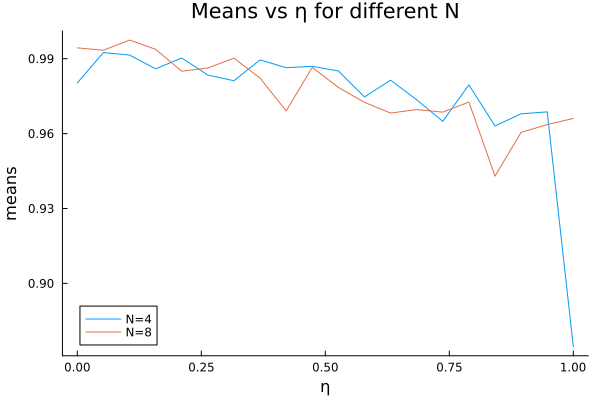

In [82]:
# Plotting
plot()
for N in N_ar
    plot!(ηs, results[N], label="N=$N")
end
plot!(xlabel="η", ylabel="means", title="Means vs η for different N", grid=false)


Can make it converge if we make the message passing really slow.

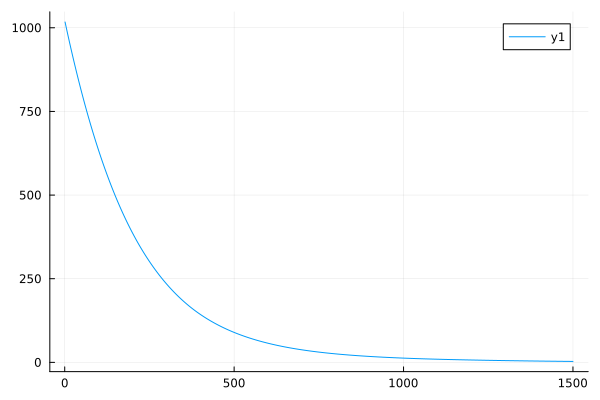

In [24]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.04,ti=false)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.005,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

Add some noise in the updates.

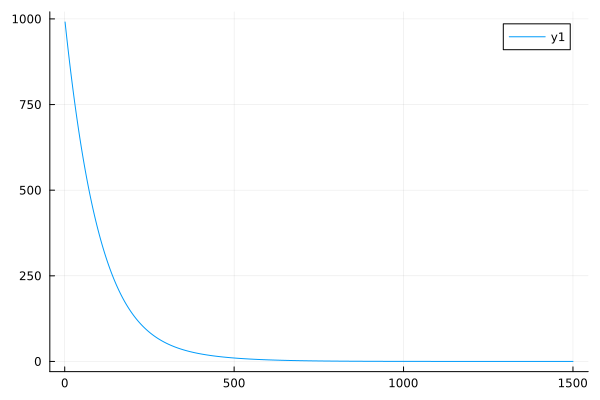

In [30]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.04,ti=false)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.01,η=0.001,max_iters=1500,diagnose=true)
plot(arr)

Turn on translational invariance. Works for much higher $\eta$ values.

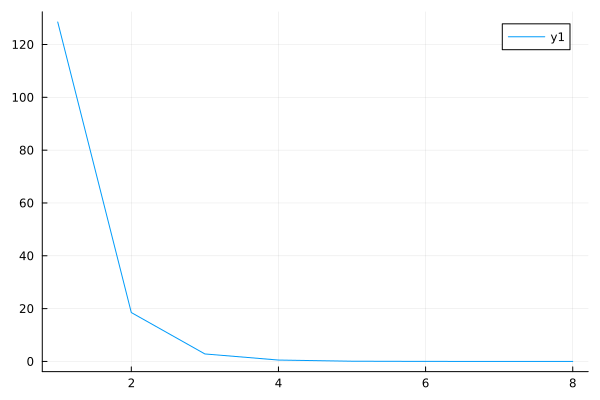

In [10]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.5,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

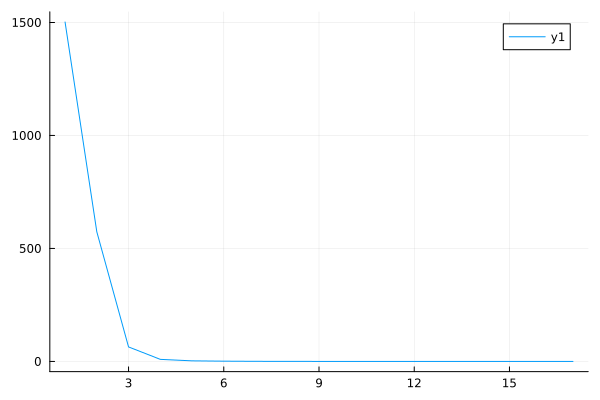

In [11]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.75,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

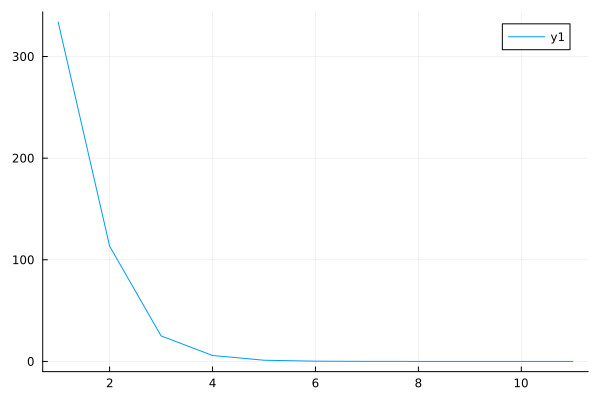

In [12]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=0.95,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)

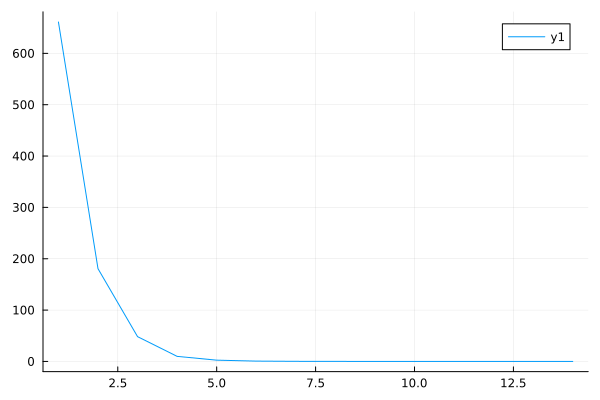

In [13]:
N = 24 
T = 32
tensors = peps_controllable(N,T;η=1.,ti=true)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages, arr = BP.message_passing(tensors,messages,edges,links,adj_mat;α=.9,η=0.0,max_iters=1500,diagnose=true)
plot(arr)